<a href="https://colab.research.google.com/github/Osmanov-Bairam/Gender-detection-/blob/main/Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the problem

## Предсказание пола клиента

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

# Import libraries

Imort and install all neccessery libraries

In [1]:
%%capture

!pip install scikit-learn-intelex;

In [2]:
%%capture

!pip install catboost;

In [3]:
%%capture

!pip install shap;

In [4]:
# load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
pandas version: 1.3.5
matplotlib version: 3.2.2
NumPy version: 1.19.5
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 1.0.2
-------------------------


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
# other libraries
import random
import time
import os
import requests
import collections
import pickle
from tqdm import tqdm

In [6]:
# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Uncommon Model Algorithms
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from catboost import Pool

# to split the datasets
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# from pandas.tools.plotting import scatter_matrix
import missingno as msno


In [7]:
! pip install feature-engine

In [8]:
# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    RandomSampleImputer,
    EndTailImputer,
    CategoricalImputer
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.discretisation import EqualWidthDiscretiser

# Presetting

In [9]:
# To plot pretty figures

#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [10]:
# Connect to google drive to get access to data

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [11]:
# Where to save the figures

IMAGES_PATH = "/content/gdrive/MyDrive/Projects/Assessment/Plots"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [12]:
path_pikcle = "/content/gdrive/MyDrive/Projects/Assessment/Pickles"

# Gather & Import the data

In [ ]:
# load dataset from google drive folders

path_gender = "/content/gdrive/MyDrive/Projects/Assessment/data/gender.csv"
path_tr_mcc_codes = "/content/gdrive/MyDrive/Projects/Assessment/data/tr_mcc_codes.csv"
path_tr_types = "/content/gdrive/MyDrive/Projects/Assessment/data/tr_types.csv"
path_transactions = "/content/gdrive/MyDrive/Projects/Assessment/data/transactions.csv"

data_gender = pd.read_csv(path_gender)
data_tr_mcc_codes = pd.read_csv(path_tr_mcc_codes, sep=';')
data_tr_types = pd.read_csv(path_tr_types, sep=';')
data_transactions = pd.read_csv(path_transactions, sep=',')

# Meet and Greet Data

Let's familiarize ourselves with data

In [ ]:
data_gender.head(3)

,customer_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0


In [ ]:
data_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  12000 non-null  int64  
 1   gender       8400 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 187.6 KB


In [ ]:
data_tr_mcc_codes.head(3)

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству


In [ ]:
data_tr_mcc_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mcc_code         184 non-null    int64 
 1   mcc_description  184 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [ ]:
data_tr_types.head(10)

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...
5,4010,Плата за получение наличных в АТМ Сбербанка
6,4011,Плата за получение наличных в АТМ Сбербанка (в...
7,4020,Плата за получение наличных через POS в Сбербанке
8,4021,Плата за получение наличных через POS в Сберба...
9,4030,Плата за взнос наличных через АТМ (в своем тер...


In [ ]:
data_tr_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tr_type         155 non-null    int64 
 1   tr_description  155 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [ ]:
data_transactions.head(3)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN


In [ ]:
data_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849346 entries, 0 to 6849345
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   tr_datetime  object 
 2   mcc_code     int64  
 3   tr_type      int64  
 4   amount       float64
 5   term_id      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 313.5+ MB


In [ ]:
# data balance

data_gender["gender"].value_counts()

0.0    4651
1.0    3749
Name: gender, dtype: int64

# Combine and Split the data

In [ ]:
full_data = data_transactions.merge(data_gender, how = "left", on = "customer_id").copy()

In [ ]:
# data_train - will be used for training and validation
# data_val - will be used for data_train evaluation

# full_data - will be used for final training 
# test_data - will be used for final training evaluation


data = full_data[~full_data["gender"].isnull()].sort_values(by=['customer_id'])
data_test = full_data[full_data["gender"].isnull()].sort_values(by=['customer_id'])

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import KFold

# split = KFold(n_splits=2)

# for train_index, test_index in split.split(data, data["gender"]):
#   strat_train_set = data.iloc[train_index]
#   strat_test_set = data.iloc[test_index]

In [ ]:
# data_train = strat_train_set.copy(deep = True)
# data_val = strat_test_set.copy(deep = True)

In [ ]:
half_id = data["customer_id"].unique()[int(data["customer_id"].nunique()/2)]
half_index = data[data["customer_id"] == half_id].index[-1]

In [ ]:
data_train = data.loc[:half_index]
data_val = data.loc[half_index:]
data_full = data.copy()

In [ ]:
print(data_train.shape)
print(data_val.shape)
print(data_full.shape)
print(data_test.shape)


(1860145, 7)
(1870570, 7)
(3730714, 7)
(3118632, 7)


In [ ]:
# check - do we have the same clients in train and val set?

list(set(data_val["customer_id"].unique()) & set(data_train["customer_id"].unique()))

[49979298]

In [ ]:
# check - do we have the same clients in full train and test set?

len(list(set(data_full["customer_id"].unique()) & set(data_train["customer_id"].unique())))

4201

In [ ]:
print(data_train["customer_id"].nunique())
print(data_val["customer_id"].nunique())
print(data_test["customer_id"].nunique())
print(full_data["customer_id"].nunique())

4201
4200
6600
15000


# Research

## Research on fullness

**Let's check how many nulls we have in each column.**

---



Saving figure Fullness of columns


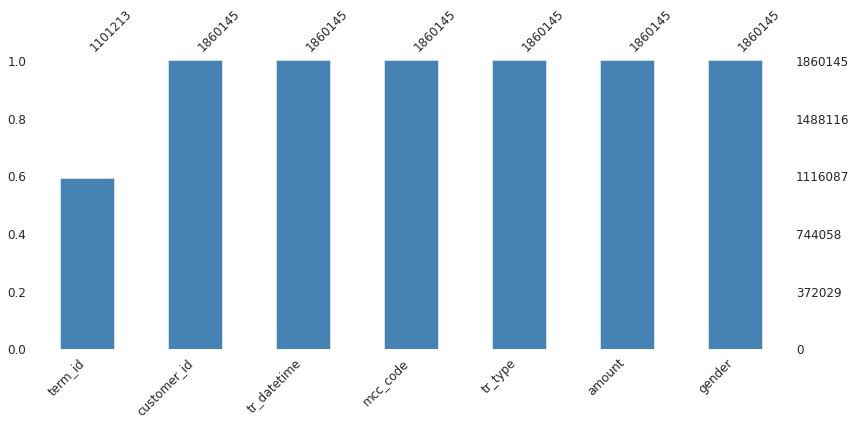

In [ ]:
# how much is null on columns level

msno.bar(data_train, figsize=(12, 6), fontsize=12, color='steelblue', sort = "ascending");
save_fig("Fullness of columns")

# Data Imputation

In [ ]:
imputed_list = {}

## Imputation technic №1

---



Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

We do not know whether data are missing at random or not. It is a good idea to replace missing observations by random value AND flag those missing observations as well with a Missing Indicator. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).



In [ ]:
pipe = Pipeline([
    ('missing_ind', AddMissingIndicator()),

    ('imputer_random', RandomSampleImputer(random_state = 42))
])

In [ ]:
# pipe.fit(data_train)

# imputed_train = pipe.transform(data_train)
# imputed_val = pipe.transform(data_val)

In [ ]:
pipe.fit(data_full)
imputed_full = pipe.transform(data_full)
imputed_test = pipe.transform(data_test)

In [ ]:
# # checking

# print("Columns with missing values in train:")
# [feature for feature in imputed_full.columns if imputed_full.isnull().any()[feature] == True]

In [ ]:
# imputed_list["imputed_train"] = imputed_train
# imputed_list["imputed_val"] = imputed_val

imputed_list["imputed_full"] = imputed_full
imputed_list["imputed_test"] = imputed_test

# Feature construction

## Sampling

In [ ]:
# create a sample to make preliminary estimation fast 

data_sample = imputed_full.copy()

data_sample["combined"] = list(zip(data_sample["customer_id"],
                          data_sample["tr_datetime"],
                          data_sample["mcc_code"],
                          data_sample["tr_type"],
                          data_sample["amount"],
                          data_sample["term_id"],
                          data_sample["gender"]))

combined_weight = data_sample['combined'].value_counts(normalize=True)

data_sample['combined_weight'] = data_sample['combined'].apply(lambda x: combined_weight[x])

sample = data_sample.sample(100000, weights=data_sample['combined_weight']).drop(["combined_weight", "combined"], axis = 1)

print(sample.shape)

(100000, 8)


In [ ]:
imputed_sample = sample.copy()

In [ ]:
imputed_list["imputed_sample"] = imputed_sample

In [ ]:
imputed_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1208076 to 1032176
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  100000 non-null  int64  
 1   tr_datetime  100000 non-null  object 
 2   mcc_code     100000 non-null  int64  
 3   tr_type      100000 non-null  int64  
 4   amount       100000 non-null  float64
 5   term_id      100000 non-null  object 
 6   gender       100000 non-null  float64
 7   term_id_na   100000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 6.9+ MB


## Creating features


In [ ]:
def construct_features(data):

  # random variable for filtering

  data["Random_variable"] = np.random.randint(1, 6, data.shape[0])
  
  # convert time data for the whole dataset first

  splitted = data["tr_datetime"].str.split(' ', expand = True)
  data["Day"] = pd.DataFrame(splitted[0]).astype("int64")
  data["Time"] = pd.DataFrame(splitted[1].str.split(':', expand = True)[0]).astype("int64")

  # amount per transaction

  data["Mean_net_money_per_transaction"] = data.groupby(['customer_id'])["amount"].transform("mean")
  data["Std_net_money_per_transaction"] = data.groupby(['customer_id'])["amount"].transform("std").fillna(0)

  func = lambda x: x.values[0] if x[x < 0].count() == 1 else x[x < 0].mean()
  data["Mean_spend_money_per_transaction"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)
  func = lambda x: x.values[0] if x[x > 0].count() == 1 else x[x > 0].mean()
  data["Mean_earn_money_per_transaction"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)

  func = lambda x: x[x < 0].std()
  data["Money_spend_std_per_transaction"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)
  func = lambda x: x[x > 0].std()
  data["Mean_earn_std_per_transaction"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)

  data["Money_earn_spend_ratio_per_transaction"] = (data["Mean_earn_money_per_transaction"].abs() / data["Money_spend_std_per_transaction"].abs()).fillna(0)
  data["Money_earn_spend_ratio_per_transaction"].replace(np.inf, 1000, inplace = True)

  print("amount per transaction is completed")
  
  # amount all

  data["ALL_money_net"] = data.groupby(['customer_id'])["amount"].transform("sum")

  func = lambda x: x[x < 0].sum()
  data["ALL_money_spend"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)
  func = lambda x: x[x > 0].sum()
  data["ALL_money_earn"] = data.groupby(['customer_id'])["amount"].transform(func).fillna(0)

  data["ALL_money_spend_earn_ratio"] = (data["ALL_money_spend"].abs() / data["ALL_money_earn"].abs())
  data["ALL_money_spend_earn_ratio"].replace(np.inf, 1000, inplace = True)

  print("amount all is completed")
  
  # frequency of transactions

  data["Frequency_of_spending_per_day"] =  data.groupby(['customer_id','Day'])['Day'].transform("count")
  data["Frequency_of_spending_all"] =  data.groupby(['customer_id'])['Day'].transform("count")
  func = lambda x: (x.count()/7)
  data["Frequency_of_spending_per_week"] = data.groupby(['customer_id'])['Day'].transform(func)

  data["Hours_std_transaction_per_day"] = data.groupby(['customer_id','Day'])['Time'].transform("std").fillna(0)

  print("frequency is completed")

  # habits

  data["Terminal_habit"] = data.groupby(['customer_id','term_id'])['term_id'].transform("count").fillna(0)
  data["Terminal_habit_sum_money"] = data.groupby(['customer_id','term_id'])['amount'].transform("sum").fillna(0)
  data["Terminal_habit_money"] =data.groupby(['customer_id','term_id'])['amount'].transform("mean").fillna(0)

  data["Service_habit"] = data.groupby(['customer_id','tr_type'])['tr_type'].transform("count").fillna(0)

  data["Product_habit_frequency"] = data.groupby(['customer_id','mcc_code'])['mcc_code'].transform("count").fillna(0)
  data["Product_habit_sum_money"] = data.groupby(['customer_id','mcc_code'])['amount'].transform("sum").fillna(0)
  data["Product_habit_mean_money"] = data.groupby(['customer_id','mcc_code'])['amount'].transform("mean").fillna(0)

  print("habits is completed")

  # amount per day

  data["Mean_net_money_per_day"] = data.groupby(['customer_id','Day'])["amount"].transform("mean")
  data["Std_net_money_per_day"] = data.groupby(['customer_id','Day'])["amount"].transform("std").fillna(0)

  func = lambda x: x.values[0] if x[x < 0].count() == 1 else x[x < 0].mean()
  data["Mean_spend_money_per_day"] = data.groupby(['customer_id','Day'])["amount"].transform(func).fillna(0)
  func = lambda x: x.values[0] if x[x > 0].count() == 1 else x[x > 0].mean()
  data["Mean_earn_money_per_day"] = data.groupby(['customer_id','Day'])["amount"].transform(func).fillna(0)

  print("amount per day is completed")

  print("Feature construction is completed")

## Implement feature construction

In [ ]:
for key, value in imputed_list.items():
  construct_features(value)
  print("===========================================")
  print(f"For imputed data {key} ALL features are created")
  print("===========================================")

amount per transaction is completed
amount all is completed
frequency is completed
habits is completed
amount per day is completed
Feature construction is completed
For imputed data imputed_full ALL features are created
amount per transaction is completed
amount all is completed
frequency is completed
habits is completed
amount per day is completed
Feature construction is completed
For imputed data imputed_test ALL features are created
amount per transaction is completed
amount all is completed
frequency is completed
habits is completed
amount per day is completed
Feature construction is completed
For imputed data imputed_sample ALL features are created


In [ ]:
# # checking for null columns
# for key, value in imputed_list.items():
#   print(f"Columns with missing values fot {key}:")
#   print([feature for feature in value.columns if value.isnull().any()[feature] == True])

In [ ]:
cat_features = ['mcc_code', 'tr_type', 'term_id', 'term_id_na', 'Time']
num_features = ['amount', "Day", 'Mean_net_money_per_day', 'Std_net_money_per_day',
       'Mean_spend_money_per_day', 'Mean_earn_money_per_day',
       'Money_spend_std_per_day', 'Mean_earn_std_per_day',
       'Money_earn_spend_ratio_per_day', 'ALL_money_net', 'ALL_money_spend',
       'ALL_money_earn', 'ALL_money_spend_earn_ratio',
       'Frequency_of_spending_per_day', 'Frequency_of_spending_all',
       'Frequency_of_spending_per_week', 'Hours_std_transaction_per_day']
       
filtered_features = cat_features + num_features


#№ change type of cat_features        

print('Всего столбцов', len(imputed_sample.columns))  
print('Численных признаков', len(num_features))
print('Категориальных признаков', len(cat_features))

Всего столбцов 37
Численных признаков 17
Категориальных признаков 5


In [ ]:
for key, value in imputed_list.items():
  value[cat_features] = value[cat_features].astype("str")

In [ ]:
# save imputed data to skip imputation step in the future

pickle_out = open(path_pikcle + "imputed_list.pickle", "wb")
pickle.dump(imputed_list, pickle_out)
pickle_out.close()

# Exploratory Analysis with Statistics (In development)

As our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3146330c10>,
      dtype=object)

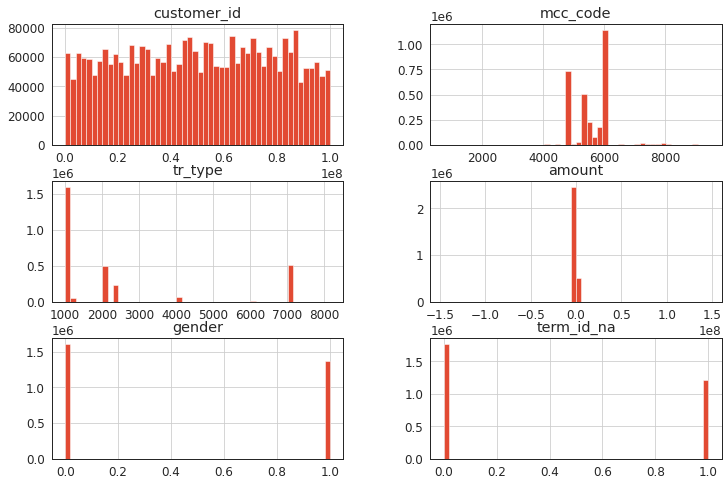

In [ ]:
imputed_sample.hist(bins = 50)

# Baseline model


Here I am going to use simple Decision tree model with simple imputation and and simple encoding

### Categorical Encoding using Count or frequency encoding

In [ ]:
# load imputed data 

pickle_in = open(path_pikcle + "imputed_list.pickle", "rb")
list_data = pickle.load(pickle_in)

In [ ]:
list_data.keys()

dict_keys(['imputed_full', 'imputed_test', 'imputed_sample'])

In [ ]:
# drop some variables
data_sample = list_data["imputed_sample"]

In count encoding we replace the categories by the count of the observations that show that category in the dataset.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.

Disadvantages

If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

In [ ]:
# find categorical variables
# those of type 'Object' in the dataset
features_categorical =  [c for c in data_sample.columns if data_sample[c].dtypes=='O']

In [ ]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=features_categorical)

count_enc.fit(data_sample)

CountFrequencyEncoder(encoding_method='frequency',
                      variables=['tr_datetime', 'mcc_code', 'tr_type',
                                 'term_id', 'term_id_na', 'Time'])

In [ ]:
# perform encoding

X_sample = count_enc.transform(data_sample)

Here we will create new features manually. There is a way to do that using nueral networks automatically. But we will not consider that approach in this notebook.

In [ ]:
X_sample.columns

Index(['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount',
       'term_id', 'gender', 'term_id_na', 'Random_variable', 'Day', 'Time',
       'Mean_net_money_per_transaction', 'Std_net_money_per_transaction',
       'Mean_spend_money_per_transaction', 'Mean_earn_money_per_transaction',
       'Money_spend_std_per_transaction', 'Mean_earn_std_per_transaction',
       'Money_earn_spend_ratio_per_transaction', 'ALL_money_net',
       'ALL_money_spend', 'ALL_money_earn', 'ALL_money_spend_earn_ratio',
       'Frequency_of_spending_per_day', 'Frequency_of_spending_all',
       'Frequency_of_spending_per_week', 'Hours_std_transaction_per_day',
       'Terminal_habit', 'Terminal_habit_sum_money', 'Terminal_habit_money',
       'Service_habit', 'Product_habit_frequency', 'Product_habit_sum_money',
       'Product_habit_mean_money', 'Mean_net_money_per_day',
       'Std_net_money_per_day', 'Mean_spend_money_per_day',
       'Mean_earn_money_per_day'],
      dtype='object')

## Fitting with base classification algorithms

In [ ]:
# check for presence of object type columns
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1208076 to 1032176
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   customer_id                             100000 non-null  int64  
 1   tr_datetime                             100000 non-null  float64
 2   mcc_code                                100000 non-null  float64
 3   tr_type                                 100000 non-null  float64
 4   amount                                  100000 non-null  float64
 5   term_id                                 100000 non-null  float64
 6   gender                                  100000 non-null  float64
 7   term_id_na                              100000 non-null  float64
 8   Random_variable                         100000 non-null  int64  
 9   Day                                     100000 non-null  int64  
 10  Time                                 

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    # ensemble.GradientBoostingClassifier(),
    # ensemble.RandomForestClassifier()

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    # linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    # linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    # naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    tree.DecisionTreeClassifier()
    # tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    # XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
#cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.KFold(n_splits = 4)

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


#create table to compare MLA predictions
target = X_sample["gender"]
train = X_sample.drop(["customer_id", "gender"], axis = 1)
MLA_predict = X_sample["gender"]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(train, target)
    MLA_predict[MLA_name] = alg.predict(train)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.4s finished


Model DecisionTreeClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.980214,0.007175,3.883446


In [ ]:
# save model for future usage

pickle_out = open(path_pikcle + "MLA_compare_baseline.pickle", "wb")
pickle.dump(MLA_compare, pickle_out)
pickle_out.close()

# Other Algorithms

### Load all imputed data

In [13]:
# load imputed data 

pickle_in = open(path_pikcle + "imputed_list.pickle", "rb")
list_data = pickle.load(pickle_in)

# imputed_train_drop = list_data["imputed_train"].drop(['tr_datetime', 'customer_id'], axis = 1)
# imputed_val_drop = list_data["imputed_val"].drop(['tr_datetime', 'customer_id'], axis = 1)

imputed_sample_drop = list_data["imputed_sample"].drop(['tr_datetime', 'customer_id'], axis = 1)

imputed_test_drop = list_data["imputed_test"].drop(['tr_datetime', 'customer_id'], axis = 1)
imputed_full_drop = list_data["imputed_full"].drop(['tr_datetime', 'customer_id'], axis = 1)

cat_features = ['mcc_code', 'tr_type', 'term_id', 'term_id_na', 'Time']

## Rare lables 

Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, infrequent labels tend to appear only on train set or only on the test set:

*   If only on the train set, they may cause over-fitting
*   If only on the test set, our machine learning model will not know how to score them.

Therefore, to avoid this behaviour, we tend to group those into a new category called 'Rare' or 'Other'.

### Cardinality

In [14]:
# let's explore a few examples in which variables have only a few categories, say less than 3

for col in cat_features:
       
      if imputed_sample_drop[col].nunique() < 3:  # if the variable has less than 3 categories
          
          # print percentage of observations per category
          print(imputed_sample_drop.groupby(col)[col].count() / len(imputed_sample_drop))
          print()

term_id_na
0    0.59657
1    0.40343
Name: term_id_na, dtype: float64



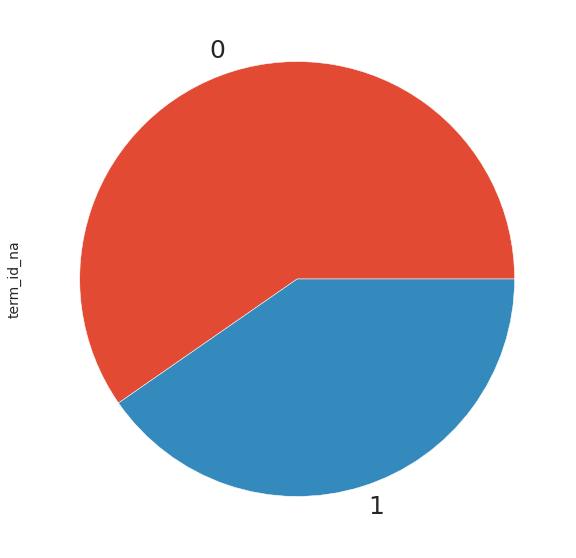

In [15]:
(imputed_sample_drop["term_id_na"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 25, figsize = (10,10));

**Variables with few categories**

In [16]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in cat_features:
  
      if 2 < imputed_sample_drop[col].nunique() <= 10: # has more than 2 but less than 10 categories
          
          multi_cat_cols.append(col)  # add to the list
          
          print(imputed_sample_drop.groupby(col)[col].count()/ len(imputed_sample_drop)) # and print the percentage of observations within each category
          
          print()

**Variable with high cardinality**

In [17]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in cat_features:

      if imputed_sample_drop[col].nunique() > 10: # and has more than 10 categories
          
          multi_cat_cols.append(col)  # add to the list
          
          print((imputed_sample_drop.groupby(col)[col].count()/len(imputed_sample_drop)).sort_values()) # and print the percentage of observations within each category
          
          print()

mcc_code
5713    0.00001
5044    0.00001
1799    0.00001
2741    0.00001
5969    0.00001
         ...   
4829    0.09256
6010    0.13038
5411    0.14273
4814    0.14751
6011    0.21750
Name: mcc_code, Length: 174, dtype: float64

tr_type
7041    0.00001
4021    0.00001
4100    0.00001
4096    0.00001
7015    0.00001
         ...   
7070    0.08745
1110    0.13798
1030    0.14529
2010    0.15511
1010    0.23229
Name: tr_type, Length: 63, dtype: float64

term_id
0  15392    0.00001
50124681    0.00001
50124707    0.00001
50124917    0.00001
50125208    0.00001
             ...   
888993      0.01818
888990      0.01821
888991      0.01841
888986      0.01878
888992      0.01891
Name: term_id, Length: 48621, dtype: float64

Time
1     0.00575
2     0.00604
3     0.00776
23    0.00940
4     0.01056
5     0.01506
22    0.01624
6     0.02014
21    0.02622
7     0.02929
20    0.03608
8     0.04062
19    0.04632
9     0.05092
18    0.05407
10    0.05875
17    0.06078
15    0.06102
11    0.0614

Saving figure Кардинальность_терминалов


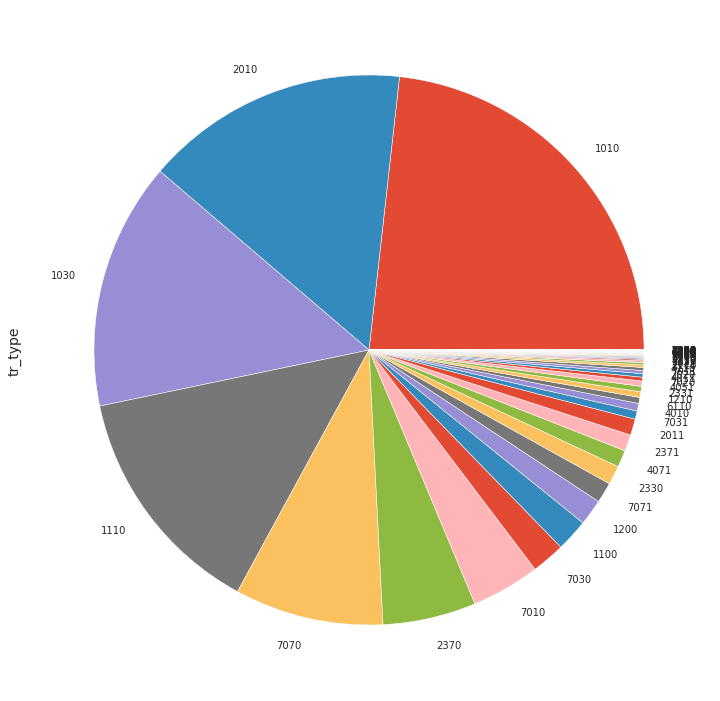

In [18]:
(imputed_sample_drop["tr_type"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 10, figsize = (10,10));
save_fig("Кардинальность_терминалов")

## Re-grouping rare labels

In [19]:
from feature_engine.encoding import RareLabelEncoder

In [20]:
# Rare value encoder
rare_encoder_1 = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=3, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['mcc_code', 'tr_type', 'Time'] # variables to re-group
)  


# Rare value encoder
rare_encoder_2 = RareLabelEncoder(
    tol=0.00005,  # minimal percentage to be considered non-rare
    n_categories=3, # minimal number of categories the variable should have to re-cgroup rare categories
    variables='term_id' # variables to re-group
)  

In [21]:
# for sample

rare_encoder_1.fit(imputed_sample_drop)
X_sample = rare_encoder_1.transform(imputed_sample_drop)

In [22]:
# for train and validation

# rare_encoder_1.fit(imputed_train_drop)
# rare_encoder_2.fit(imputed_train_drop)

# X_train = rare_encoder_1.transform(imputed_train_drop)
# X_val = rare_encoder_1.transform(imputed_val_drop)
# X_train = rare_encoder_2.transform(X_train)
# X_val = rare_encoder_2.transform(X_val)

In [23]:
# for full set and test set

rare_encoder_1.fit(imputed_full_drop)
rare_encoder_2.fit(imputed_full_drop)

X_full = rare_encoder_2.transform(rare_encoder_1.transform(imputed_full_drop))
X_test = rare_encoder_2.transform(rare_encoder_1.transform(imputed_test_drop))

Let's visualize changes

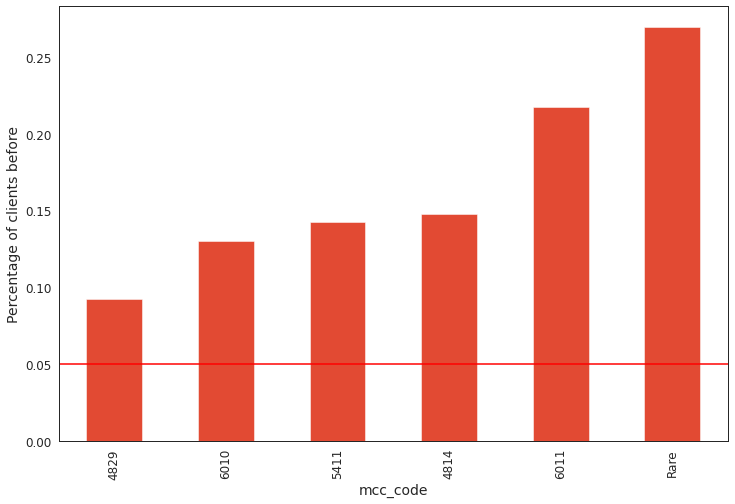

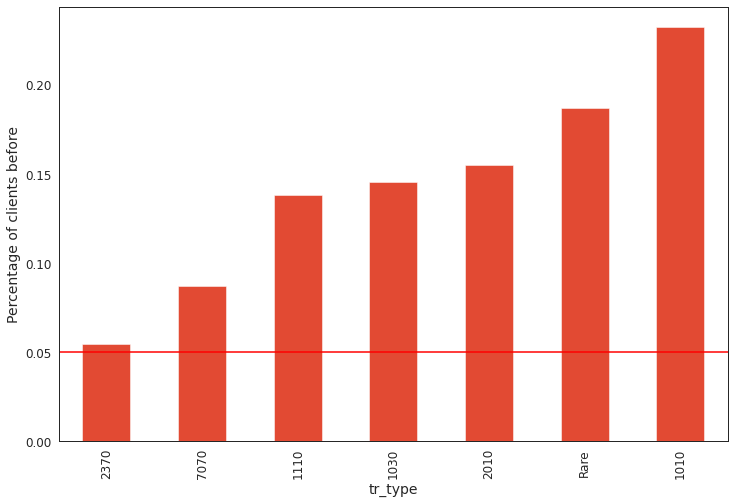

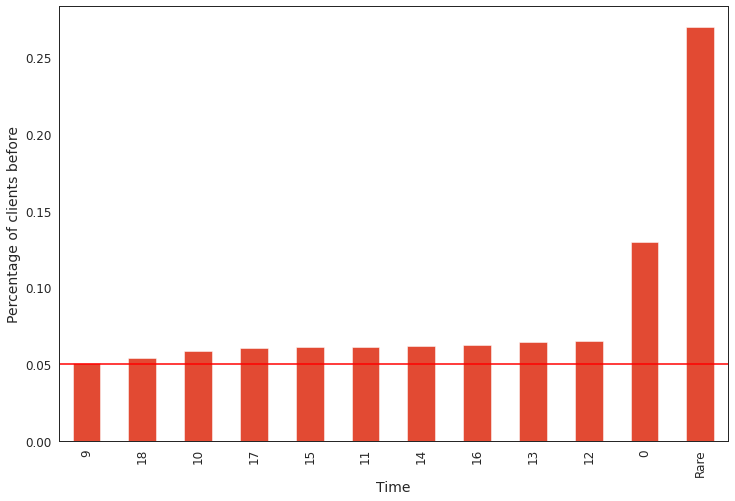

Saving figure До группировки


<Figure size 864x576 with 0 Axes>

In [24]:
for col in ['mcc_code', 'tr_type', 'Time']:

    temp_df = pd.Series((X_sample[col].value_counts() / len(X_sample)))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=True).plot.bar()
    
    fig.set_xlabel(col)


    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of clients before')
    plt.show();

save_fig("До группировки")

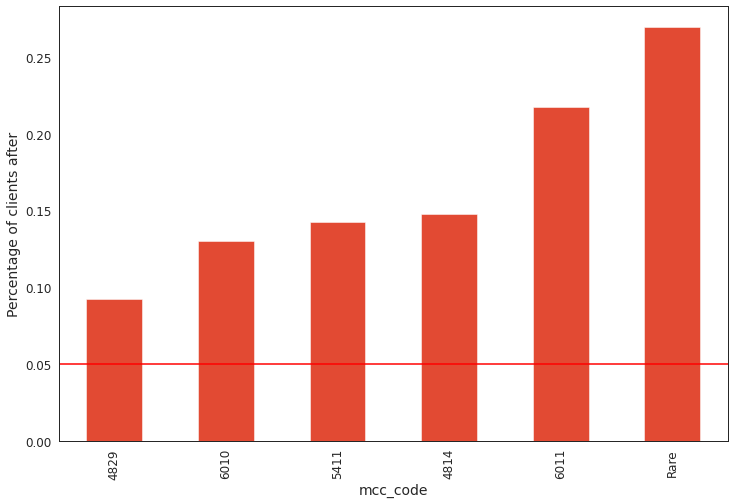

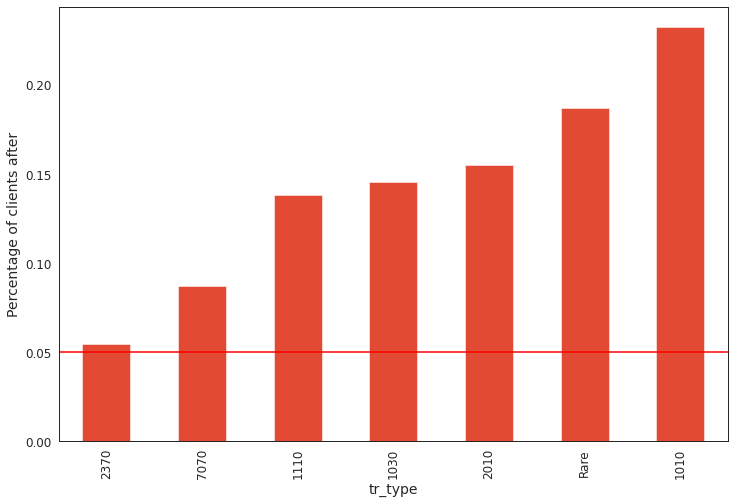

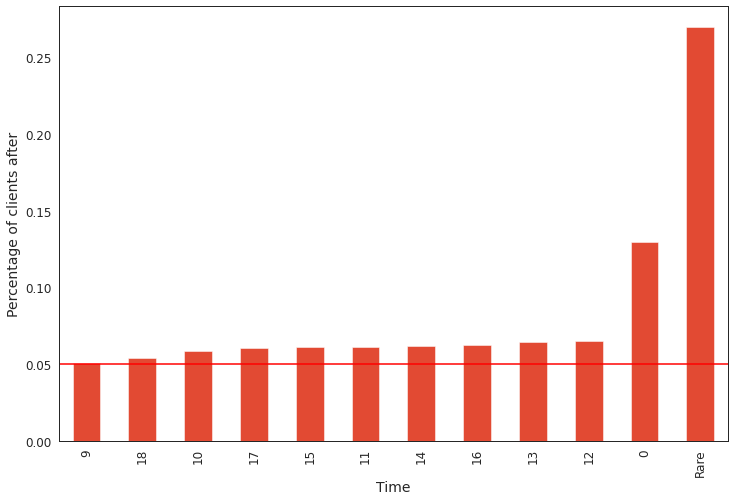

Saving figure После группировки


<Figure size 864x576 with 0 Axes>

In [25]:
for col in ['mcc_code', 'tr_type', 'Time']:

    temp_df = pd.Series((X_sample[col].value_counts() / len(X_sample)))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=True).plot.bar()
    
    fig.set_xlabel(col)


    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of clients after')
    plt.show();

save_fig("После группировки")

As we expected rare lebels are grouped together.

In [26]:
list_grouped = {}

In [27]:
# list_grouped["X_train_grouped"] = X_train
# list_grouped["X_val_grouped"] = X_val

list_grouped["X_sample_grouped"] = X_sample
list_grouped["X_full_grouped"] = X_full
list_grouped["X_test_grouped"] = X_test

In [28]:
# save encoded data to skip encoding step in the future

pickle_out = open(path_pikcle + "list_grouped.pickle", "wb")
pickle.dump(list_grouped, pickle_out)
pickle_out.close()

## Modelling with Catboost

https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python

https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=iCEU8FP8U970

In [ ]:
SEED = 42

In [ ]:
pickle_in = open(path_pikcle + "list_grouped.pickle", "rb")
list_grouped = pickle.load(pickle_in)

X_sample_grouped = list_grouped["X_sample_grouped"]

In [ ]:
X = X_sample_grouped.drop(["gender"], axis=1)
y = X_sample_grouped['gender'].values

In [ ]:
X_train_cat, X_validation, y_train_cat, y_validation = train_test_split(X, y, test_size=0.25, random_state=SEED)

**Implementation with CPU using cross-validation technic**

In [ ]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED,
          'early_stopping_rounds': 200,
          # 'task_type': 'GPU'
         }

all_train_data = Pool(data=X,
                      label=y,
                      cat_features=cat_features
                     )

start_time = time.time()

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=SEED, 
            shuffle=True,
            return_models=True,
            stratified=True # if True the folds are made by preserving the percentage of samples for each class
           )

fit_time = (time.time() - start_time)
print("Fitting was lasting: ", fit_time)

cat_boost_model_first = [scores, fit_time]

Training on fold [0/3]
0:	test: 0.6394542	best: 0.6394542 (0)	total: 291ms	remaining: 4m 51s
200:	test: 0.8048298	best: 0.8048298 (200)	total: 30.4s	remaining: 2m 1s
400:	test: 0.8618720	best: 0.8618720 (400)	total: 56.2s	remaining: 1m 23s
600:	test: 0.9082537	best: 0.9082537 (600)	total: 1m 22s	remaining: 54.7s
800:	test: 0.9325706	best: 0.9325706 (800)	total: 1m 48s	remaining: 26.9s
999:	test: 0.9486214	best: 0.9486214 (999)	total: 2m 14s	remaining: 0us

bestTest = 0.9486214079
bestIteration = 999

Training on fold [1/3]
0:	test: 0.6541197	best: 0.6541197 (0)	total: 136ms	remaining: 2m 15s
200:	test: 0.8072739	best: 0.8072739 (200)	total: 25.5s	remaining: 1m 41s
400:	test: 0.8678097	best: 0.8678097 (400)	total: 51.5s	remaining: 1m 16s
600:	test: 0.9098176	best: 0.9098176 (600)	total: 1m 17s	remaining: 51.5s
800:	test: 0.9329987	best: 0.9329987 (800)	total: 1m 43s	remaining: 25.7s
999:	test: 0.9481176	best: 0.9481176 (999)	total: 2m 9s	remaining: 0us

bestTest = 0.9481175645
bestItera

In [ ]:
# save model

pickle_out = open(path_pikcle + "cat_boost_model_first.pickle", "wb")
pickle.dump(cat_boost_model_first, pickle_out)
pickle_out.close()

## Categorical Encoding using Count or frequency encoding

In [ ]:
pickle_in = open(path_pikcle + "list_grouped.pickle", "rb")
list_grouped = pickle.load(pickle_in)

X_sample_grouped = list_grouped["X_sample_grouped"]
X_full_grouped = list_grouped["X_full_grouped"]
X_test_grouped = list_grouped["X_test_grouped"]

cat_features = ['mcc_code', 'tr_type', 'term_id', 'term_id_na', 'Time']

In count encoding we replace the categories by the count of the observations that show that category in the dataset.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.

Disadvantages

If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

In [ ]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=cat_features)

count_enc.fit(X_full_grouped)


# perform encoding

# X_train_encod = count_enc.transform(X_train)
# X_val_encod = count_enc.transform(X_val)

X_full_encod = count_enc.transform(X_full_grouped)
X_test_encod = count_enc.transform(X_test_grouped)

In [ ]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=cat_features)

count_enc.fit(X_sample_grouped)

# perform encoding
X_sample_encod = count_enc.transform(X_sample_grouped)

In [ ]:
list_encoded = {}

In [ ]:
# list_encoded["X_train_encod"] = X_train_encod
# list_encoded["X_val_encod"] = X_val_encod
list_encoded["X_full_encod"] = X_full_encod
list_encoded["X_test_encod"] = X_test_encod

list_encoded["X_sample_encod"] = X_sample_encod

In [ ]:
# save encoded data to skip encoding step in the future

pickle_out = open(path_pikcle + "list_encoded.pickle", "wb")
pickle.dump(list_encoded, pickle_out)
pickle_out.close()

## Fitting with other classification algorithms

In [ ]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)
X_sample_encod = list_encoded["X_sample_encod"]

Here we will use other classification algorithms to compete with our CatBoost baseline. Additionaly we will apply Intel(R) Extension for Scikit-learn to speed up fitting time.

1) How to use

https://intel.github.io/scikit-learn-intelex/

2) Proofs of acceleration

https://www.kaggle.com/andreyrus/tps-apr-rf-with-intel-extension-for-scikit-learn/notebook

In [ ]:
# # checking

# print("Columns with missing values in train set:")
# [feature for feature in X_sample_encod.columns if X_sample_encod.isnull().any()[feature] == True]

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
 
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    # ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    # linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    # naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    tree.DecisionTreeClassifier(),
    # tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
#cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.KFold(n_splits = 3)
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


#create table to compare MLA predictions
target = X_sample_encod["gender"].copy()
data = X_sample_encod.drop(["gender"], axis = 1).copy()
MLA_predict = X_sample_encod["gender"]

#index through MLA and save performance to table
row_index = 1
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data, target)
    MLA_predict[MLA_name] = alg.predict(data)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.4s finished


Model RandomForestClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Model RidgeClassifierCV is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Model KNeighborsClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


Model DecisionTreeClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.7s finished


Model XGBClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.992824,0.000992,15.0509
4,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.948813,0.05777,3.17254
3,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.966031,0.908709,0.0016,0.076524
5,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.753432,0.747369,0.002773,12.303101
2,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.518916,0.516236,0.145337,0.482935


In [ ]:
# save model for future usage

pickle_out = open(path_pikcle + "MLA_compare.pickle", "wb")
pickle.dump(MLA_compare, pickle_out)
pickle_out.close()

Saving figure MLA_compare


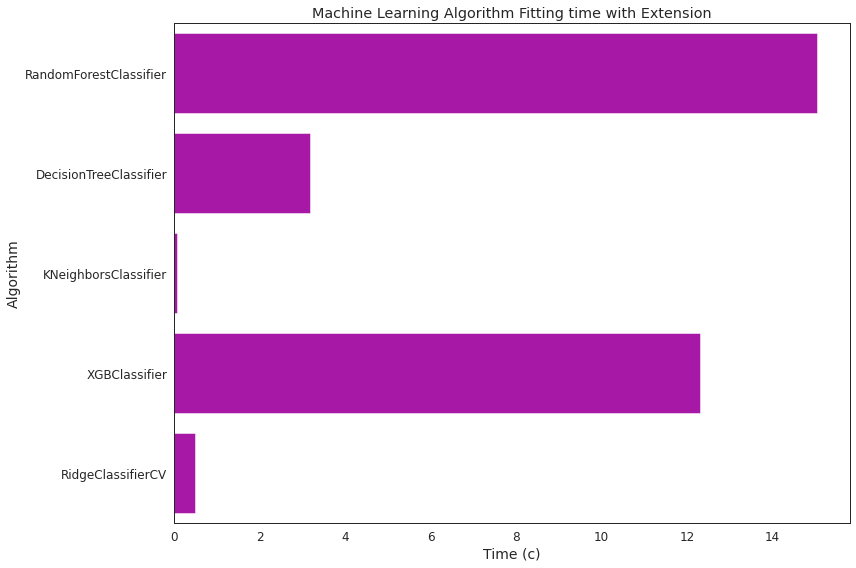

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Time', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Fitting time with Extension')
plt.xlabel('Time (c)')
plt.ylabel('Algorithm')

save_fig("MLA_compare")

## Other algorithms vs CatBoost

In [ ]:
pickle_in = open(path_pikcle + "cat_boost_model_first.pickle", "rb")
cat_boost_model_first = pickle.load(pickle_in)
pickle_in = open(path_pikcle + "MLA_compare.pickle", "rb")
MLA_compare = pickle.load(pickle_in)

In [ ]:
cv_cat_results = cat_boost_model_first[0][0]
fit_time = cat_boost_model_first[1]

In [ ]:
cv_cat_results["MLA Name"] = "CatBoost"
cv_cat_results["MLA Time"] = fit_time

In [ ]:
cv_cat_results = cv_cat_results.rename(columns={"test-AUC-mean":"MLA Test Accuracy Mean", "test-AUC-std":"MLA Test Accuracy 3*STD"});

In [ ]:
cv_cat_results = cv_cat_results[['MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Name', 'MLA Time']].max()

In [ ]:
MLA_compare = MLA_compare.append(cv_cat_results, ignore_index=True).sort_values(by = "MLA Test Accuracy Mean")
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.518916,0.516236,0.145337,0.482935
3,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.753432,0.747369,0.002773,12.303101
2,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.966031,0.908709,0.0016,0.076524
5,CatBoost,NaN,NaN,0.947715,0.01003,394.603384
1,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1.0,0.948813,0.05777,3.17254
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.0,0.992824,0.000992,15.0509


Saving figure Compare time


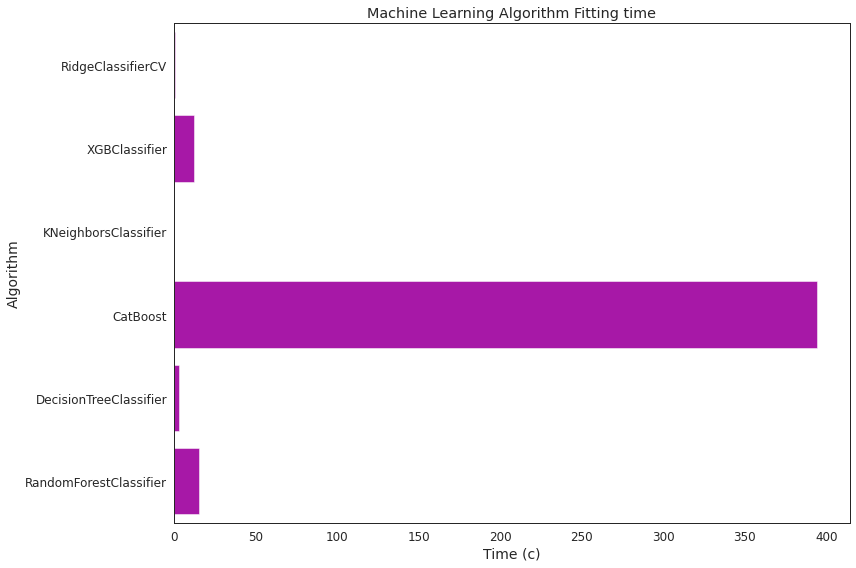

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Time', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Fitting time')
plt.xlabel('Time (c)')
plt.ylabel('Algorithm')
save_fig("Compare time")

Saving figure Compare Accuracy


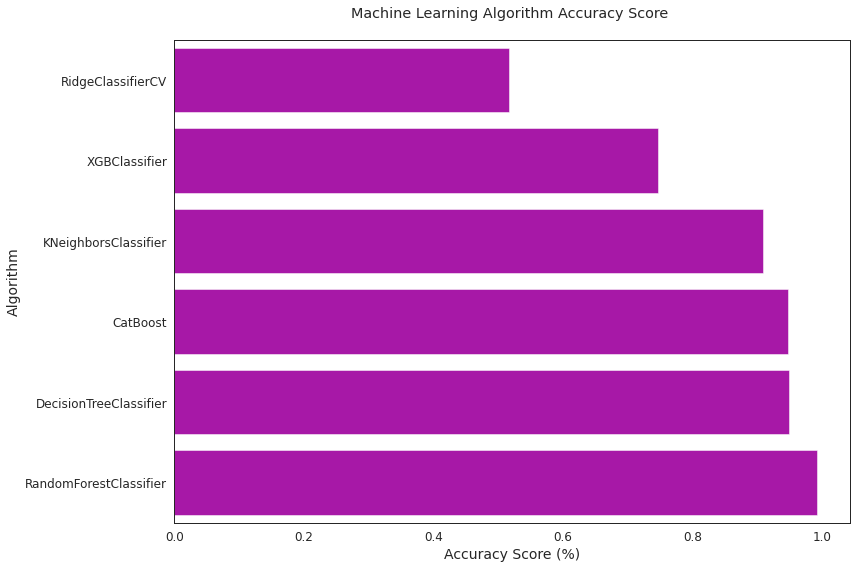

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

save_fig("Compare Accuracy")

We will choose RandomForest because it gives best score on validation test and requires less time than CatBoost. But first lets check how it predicts on unseen data by fitting on X_train_encod and validating on X_val_encod.

# Validate by RandomForest

In [ ]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)
X_train_encod = list_encoded["X_train_encod"].sample(frac=1)
X_val_encod = list_encoded["X_val_encod"].sample(frac=1)

In [ ]:
train = X_train_encod.drop(["gender"], axis = 1)
target = X_train_encod["gender"]

val = X_val_encod.drop(["gender"], axis = 1)
val_target = X_val_encod["gender"]

In [ ]:
%%time

from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import ensemble

alg = ensemble.RandomForestClassifier(max_depth=8)
alg.fit(train, target)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 44.3 s, sys: 1.15 s, total: 45.4 s
Wall time: 49.6 s


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(val_target, alg.predict_proba(val)[:, 1]) 

We get high train and validation score using X_sample_encode and low test score using X_train_encode and X_val_encode. It means that there are a lot of instances in X_val_encode that differs a lot from  X_train_encode ones.  

# Final fitting

## Before tuning

In [ ]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)
X_full_encod = list_encoded["X_full_encod"].sample(frac=1)

In [ ]:
train = X_full_encod.drop(["gender"], axis = 1)
target = X_full_encod["gender"]

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import ensemble

cv_split = model_selection.KFold(n_splits = 4)
alg = ensemble.RandomForestClassifier(max_depth=14)

base_results = model_selection.cross_validate(alg, train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True)

alg.fit(train, target)

# print('BEFORE - Parameters: ', alg.get_params())

print("BEFORE - Training score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE - Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE - Test score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE - Test set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 23.0min finished


BEFORE - Training score mean: 97.75
BEFORE - Test score mean: 97.73
BEFORE - Test score 3*std: +/- 0.51
BEFORE - Test set score min: 97.47
----------


In [ ]:
pickle_out = open(path_pikcle + "before_tuning.pickle", "wb")
pickle.dump(alg, pickle_out)

pickle_out.close()

In [ ]:
pickle_out = open(path_pikcle + "base_results_before_tuning.pickle", "wb")
pickle.dump(base_results, pickle_out)

pickle_out.close()

## After feature selection

In [76]:
pickle_in = open(path_pikcle + "before_tuning.pickle", "rb")
alg = pickle.load(pickle_in)

In [77]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)
X_full_encod = list_encoded["X_full_encod"].sample(frac=1)

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [78]:
import time
import numpy as np

start_time = time.time()
importances = alg.feature_importances_
std = np.std([tree.feature_importances_ for tree in alg.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.033 seconds


Saving figure Важность


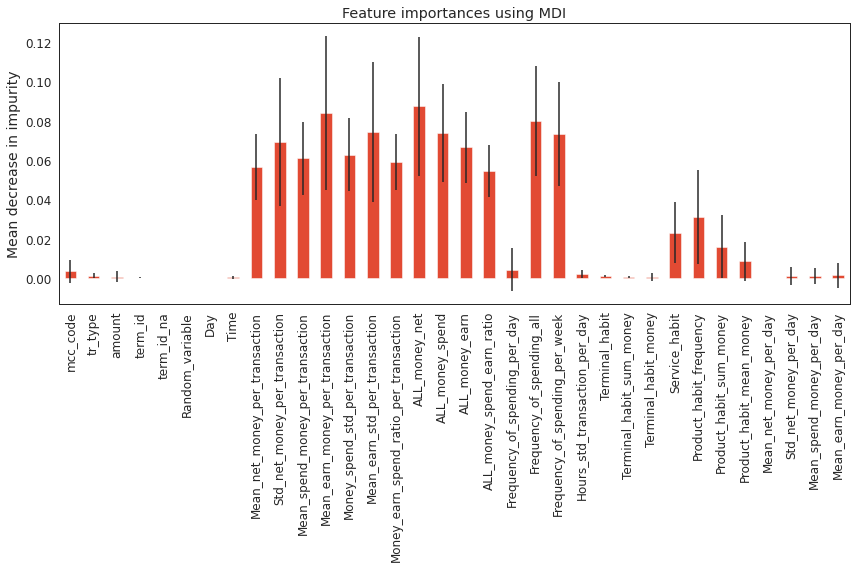

In [79]:
import pandas as pd

feature_names = X_full_encod.drop(['gender'], axis = 1).columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

save_fig("Важность")

In [80]:
good_features = forest_importances[forest_importances > 0.04].index.to_list()
good_features

['Mean_net_money_per_transaction',
 'Std_net_money_per_transaction',
 'Mean_spend_money_per_transaction',
 'Mean_earn_money_per_transaction',
 'Money_spend_std_per_transaction',
 'Mean_earn_std_per_transaction',
 'Money_earn_spend_ratio_per_transaction',
 'ALL_money_net',
 'ALL_money_spend',
 'ALL_money_earn',
 'ALL_money_spend_earn_ratio',
 'Frequency_of_spending_all',
 'Frequency_of_spending_per_week']

In [81]:
train = X_full_encod.drop(["gender"], axis = 1)[good_features]
target = X_full_encod["gender"]

In [82]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import ensemble

cv_split = model_selection.KFold(n_splits = 4)
alg = ensemble.RandomForestClassifier(max_depth=14)

base_results = model_selection.cross_validate(alg, train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True)

alg.fit(train, target)

print('AFTER - Parameters: ', alg.get_params())

print("AFTER - Training score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("AFTER - Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("AFTER - Test score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("AFTER - Test set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 15.1min finished


AFTER - Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'maxBins': 256, 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'minBinSize': 1, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
AFTER - Training score mean: 99.27
AFTER - Test score mean: 99.26
AFTER - Test score 3*std: +/- 0.18
AFTER - Test set score min: 99.20
----------


In [83]:
pickle_out = open(path_pikcle + "after_selection.pickle", "wb")
pickle.dump(alg, pickle_out)

pickle_out.close()

In [84]:
pickle_out = open(path_pikcle + "base_results_after_selection.pickle", "wb")
pickle.dump(base_results, pickle_out)

pickle_out.close()

## SHAP

In [13]:
good_features = ['Mean_net_money_per_transaction',
 'Std_net_money_per_transaction',
 'Mean_spend_money_per_transaction',
 'Mean_earn_money_per_transaction',
 'Money_spend_std_per_transaction',
 'Mean_earn_std_per_transaction',
 'Money_earn_spend_ratio_per_transaction',
 'ALL_money_net',
 'ALL_money_spend',
 'ALL_money_earn',
 'ALL_money_spend_earn_ratio',
 'Frequency_of_spending_all',
 'Frequency_of_spending_per_week']

In [14]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)

X_sample_encod = list_encoded["X_sample_encod"]

In [15]:
train = X_sample_encod.drop(["gender"], axis = 1)
target = X_sample_encod["gender"]

In [16]:
import xgboost as xgb

dmat = xgb.DMatrix(train, target)
params = {"tree_method": "gpu_hist",
          "eval_metric": "auc"}

bst = xgb.train(params, dmat, num_boost_round=50)

In [17]:
cv = xgb.cv(params, dmat, nfold=4,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=42)

In [18]:
cv.sort_values(by = ["test-auc-mean"], ascending=False).head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
49,0.954891,0.003224,0.942821,0.002551
48,0.954033,0.003354,0.942234,0.002809
47,0.952694,0.004005,0.940735,0.003483
46,0.950903,0.004679,0.938797,0.004283
45,0.949273,0.004310,0.937197,0.003962


In [19]:
# Make sure GPU prediction is enabled
# Set "cpu_predictor" to use CPU
bst.set_param({"predictor": "gpu_predictor"})

# Compute our shap values
start = time.time()
shap_values = bst.predict(dmat, pred_contribs=True)
print("SHAP time {}".format(time.time() - start))

SHAP time 56.02846884727478


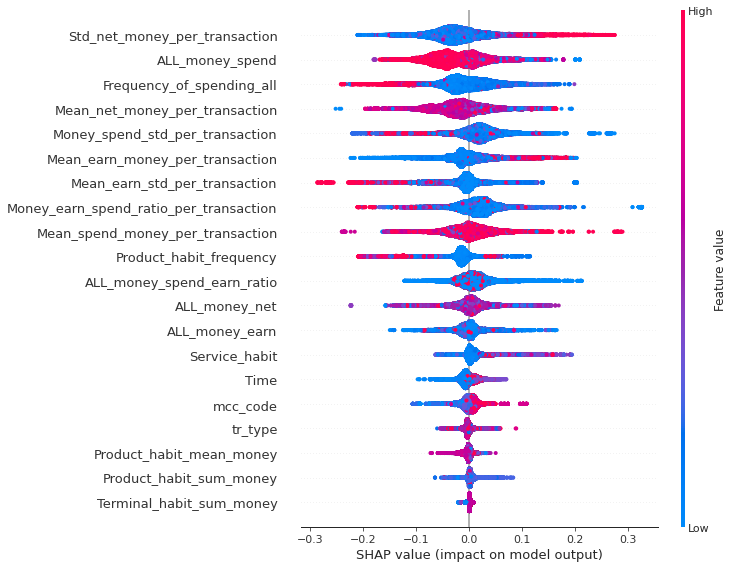

Saving figure Shap


<Figure size 864x576 with 0 Axes>

In [20]:
import shap
shap.summary_plot(shap_values[:,:-1], train)
save_fig("Shap")

On the above diagram every client (instance/row in our dataset) is represented by one dot in each row. The x position of the dot is the impact of that feature on the model’s prediction, and the color of the dot represents the value of that feature for that exact employee. Dots that do not fit on the row pile up to show density.

https://www.kaggle.com/dansbecker/shap-values

## FOR ASSESMENT

In [89]:
pickle_in = open(path_pikcle + "after_selection.pickle", "rb")
alg = pickle.load(pickle_in)

In [90]:
good_features = ['Mean_net_money_per_transaction',
 'Std_net_money_per_transaction',
 'Mean_spend_money_per_transaction',
 'Mean_earn_money_per_transaction',
 'Money_spend_std_per_transaction',
 'Mean_earn_std_per_transaction',
 'Money_earn_spend_ratio_per_transaction',
 'ALL_money_net',
 'ALL_money_spend',
 'ALL_money_earn',
 'ALL_money_spend_earn_ratio',
 'Frequency_of_spending_all',
 'Frequency_of_spending_per_week']

In [91]:
pickle_in = open(path_pikcle + "list_encoded.pickle", "rb")
list_encoded = pickle.load(pickle_in)
X_test_encod = list_encoded["X_test_encod"][good_features]

In [92]:
result = alg.predict(X_test_encod)

In [93]:
X_test_encod["gender"] = result

In [94]:
X_test_encod.head()

,Mean_net_money_per_transaction,Std_net_money_per_transaction,Mean_spend_money_per_transaction,Mean_earn_money_per_transaction,Money_spend_std_per_transaction,Mean_earn_std_per_transaction,Money_earn_spend_ratio_per_transaction,ALL_money_net,ALL_money_spend,ALL_money_earn,ALL_money_spend_earn_ratio,Frequency_of_spending_all,Frequency_of_spending_per_week,gender
1453476,-5528.561372,168370.985787,-17981.854409,451092.183333,29652.262014,990028.956041,15.212741,-1249454.87,-3956007.97,2706553.1,1.461641,226,32.285714,0.0
1453557,-5528.561372,168370.985787,-17981.854409,451092.183333,29652.262014,990028.956041,15.212741,-1249454.87,-3956007.97,2706553.1,1.461641,226,32.285714,0.0
1453556,-5528.561372,168370.985787,-17981.854409,451092.183333,29652.262014,990028.956041,15.212741,-1249454.87,-3956007.97,2706553.1,1.461641,226,32.285714,0.0
1453555,-5528.561372,168370.985787,-17981.854409,451092.183333,29652.262014,990028.956041,15.212741,-1249454.87,-3956007.97,2706553.1,1.461641,226,32.285714,0.0
1453554,-5528.561372,168370.985787,-17981.854409,451092.183333,29652.262014,990028.956041,15.212741,-1249454.87,-3956007.97,2706553.1,1.461641,226,32.285714,0.0


In [95]:
X_test_encod["gender"].value_counts()

0.0    1849342
1.0    1269290
Name: gender, dtype: int64

## After tuning

In [ ]:
train = X_full_encod.drop(["gender"], axis = 1)[good_features]
target = X_full_encod["gender"]

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import tree

cv_split = model_selection.KFold(n_splits = 4)
alg = tree.DecisionTreeClassifier()

#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              # 'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              # 'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

tune_model = model_selection.GridSearchCV(alg, param_grid=param_grid, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True)
tune_model.fit(train, target)

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER TUNING - Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER TUNING - Training score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER TUNING - Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER TUNING - Test score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)